# **ResHedNet for Domain Walls Finding**

Dec, 2025
*   Modified by Ralph Bulanadi for use with Auto-3DPFM data for the 2025 Microscopy Hackathon

June, 2021


*   Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)

*   ResHedNet realized by [AtomAi](https://atomai.readthedocs.io/en/latest/) by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)

*   Analysis and implementation by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)





**Package Version**


*   AtomAi: 0.7.4
*   Numpy: 1.21.6
*   Matplotlib: 3.2.2
*   Torch: 1.11.0+cu113
*   CV2: 4.1.2





# **Install, Import, and Download**


*   Install and import required packages
*   Download train, test, and target PFM data set



In [1]:
# !pip install imgaug==0.2.6
!pip install atomai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.5 MB/s eta 0:00:00
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174958 sha256=f0af0d735b8f67fd78237cb3c3841686db518e0c65db9fc2e36711669cb6c0f0
  Stored in directory: /root/.cache/pip/wheels/80/94/4c/df5677f3568e71c6af01d54151a79e934f6f8c4b274bcad119
Successfully built mendeleev


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from atomai.utils import extract_patches_
import atomai as aoi

import torch
import torch.nn as nn
import torch.nn.functional as F

import glob

# **Prepare train data**


*   Extract subimages and corresponding labeled wall maps from images
*   Totally xxxx subimages and corresponding xxxx wall maps were prepared for training
*   All subimages and wall maps were spilted into 80% and 20% as train data and validation data, respectively.



Define a function to extract sub_ images and _labeled walls

In [2]:
#title Define function: extract_subimage
def extract_subimage2 (x_train, y_train):
  #set patch number and patch size
  numpatches = 2000
  patchsize = 250

  #read and normalize x_train
  img = np.load(x_train)
  img = (img - img.min()) / np.ptp(img)
  noise = np.random.randn(256, 256)
  img = (img - img.min()) / np.ptp(img)

  #read and normalize y_train
  lab = np.load(y_train)
  lab = (lab - lab.min()) / np.ptp(lab)

  print(np.shape(lab))

  #if len(lab.shape) == 3:
  #  lab = lab[:,:,1]
  #else:
  #  lab = lab
  #lab = (lab - lab.min()) / np.ptp(LazyBatchNorm1d)
  #_, lab = cv2.threshold(lab, 0.7, 1, cv2.THRESH_BINARY)
  #idx_ = np.asarray(np.where(lab==1))
  #idx = idx_/(652/256)
  #idx = idx.astype(int)
  #lab = np.zeros((256,256))
  #lab[idx[0,],idx[1,]]=1
  plt.imshow(lab)
  plt.show()
  plt.close()

  #generate training batch
  imgs, labs = extract_patches_(img, lab, patch_size=patchsize, num_patches=numpatches, random_state=42)

  #return subimage and label sets
  return imgs, labs

['Image2_type123.npy', 'Image3_type123.npy', 'Image_1V_type123.npy', 'Image_8um_type123.npy']
(255, 255)


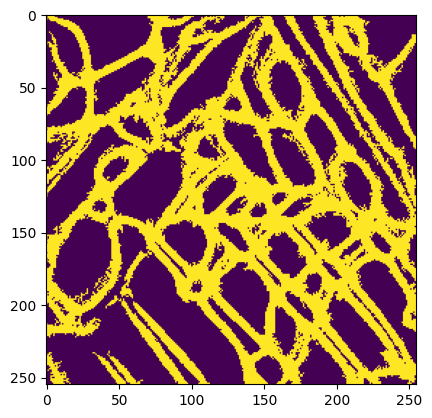

(255, 255)


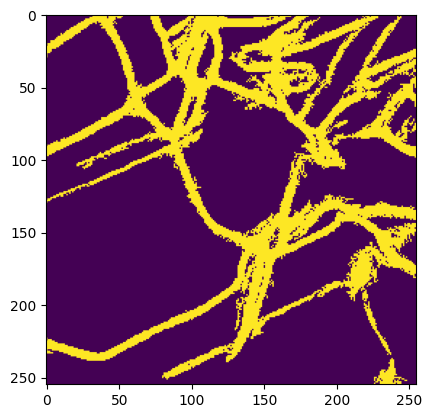

(511, 511)


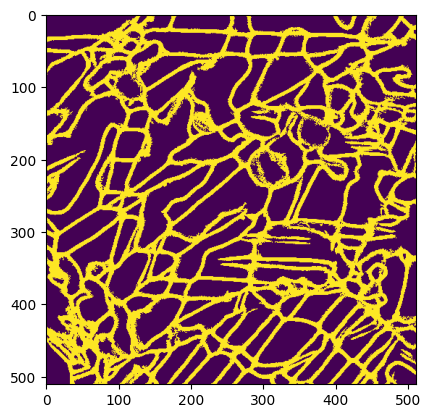

(509, 510)


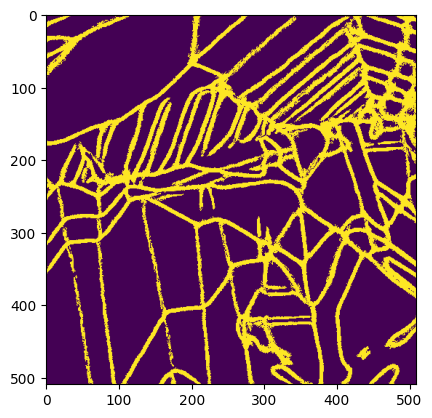

In [3]:
#PZT
xtrain_load = sorted(glob.glob('*U_mag.npy'))[:-1]

ytrain_load = sorted(glob.glob('*type123.npy'))[:-1]
print(ytrain_load)

#set xtrain and ytrain datasets
xtrain = np.empty([0,250,250])
ytrain = np.empty([0,250,250])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage2(x_train = i, y_train = j)
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)

In [4]:
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Show train and validation images

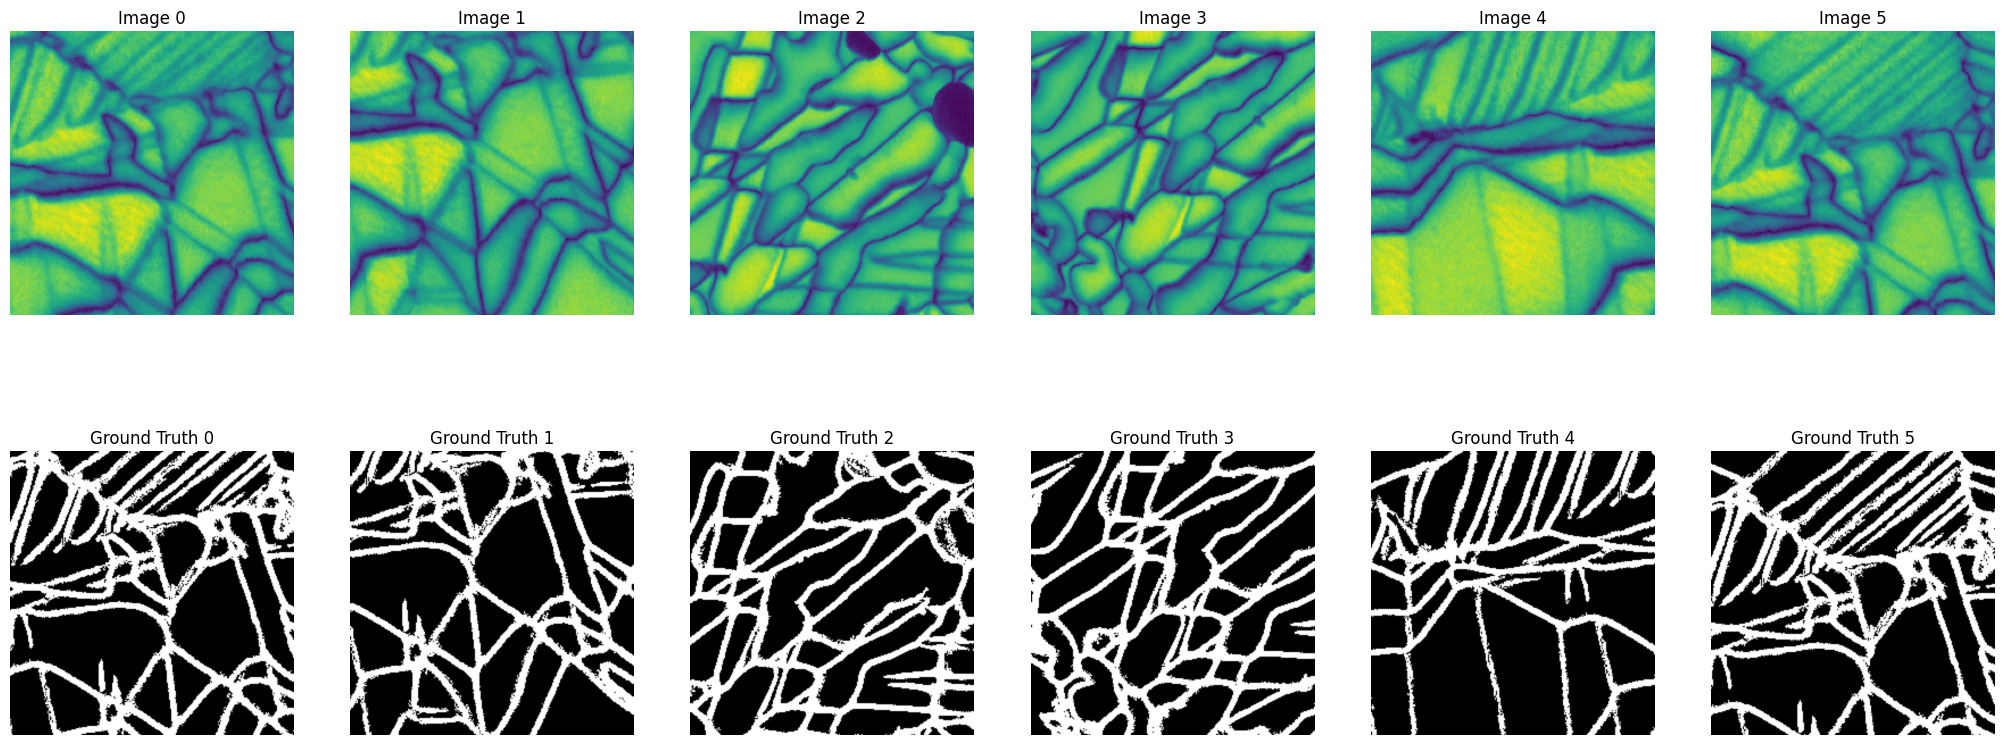

In [5]:
# show training images
n = 5

n = n + 2
fig = plt.figure(figsize=(30, 10))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_train[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

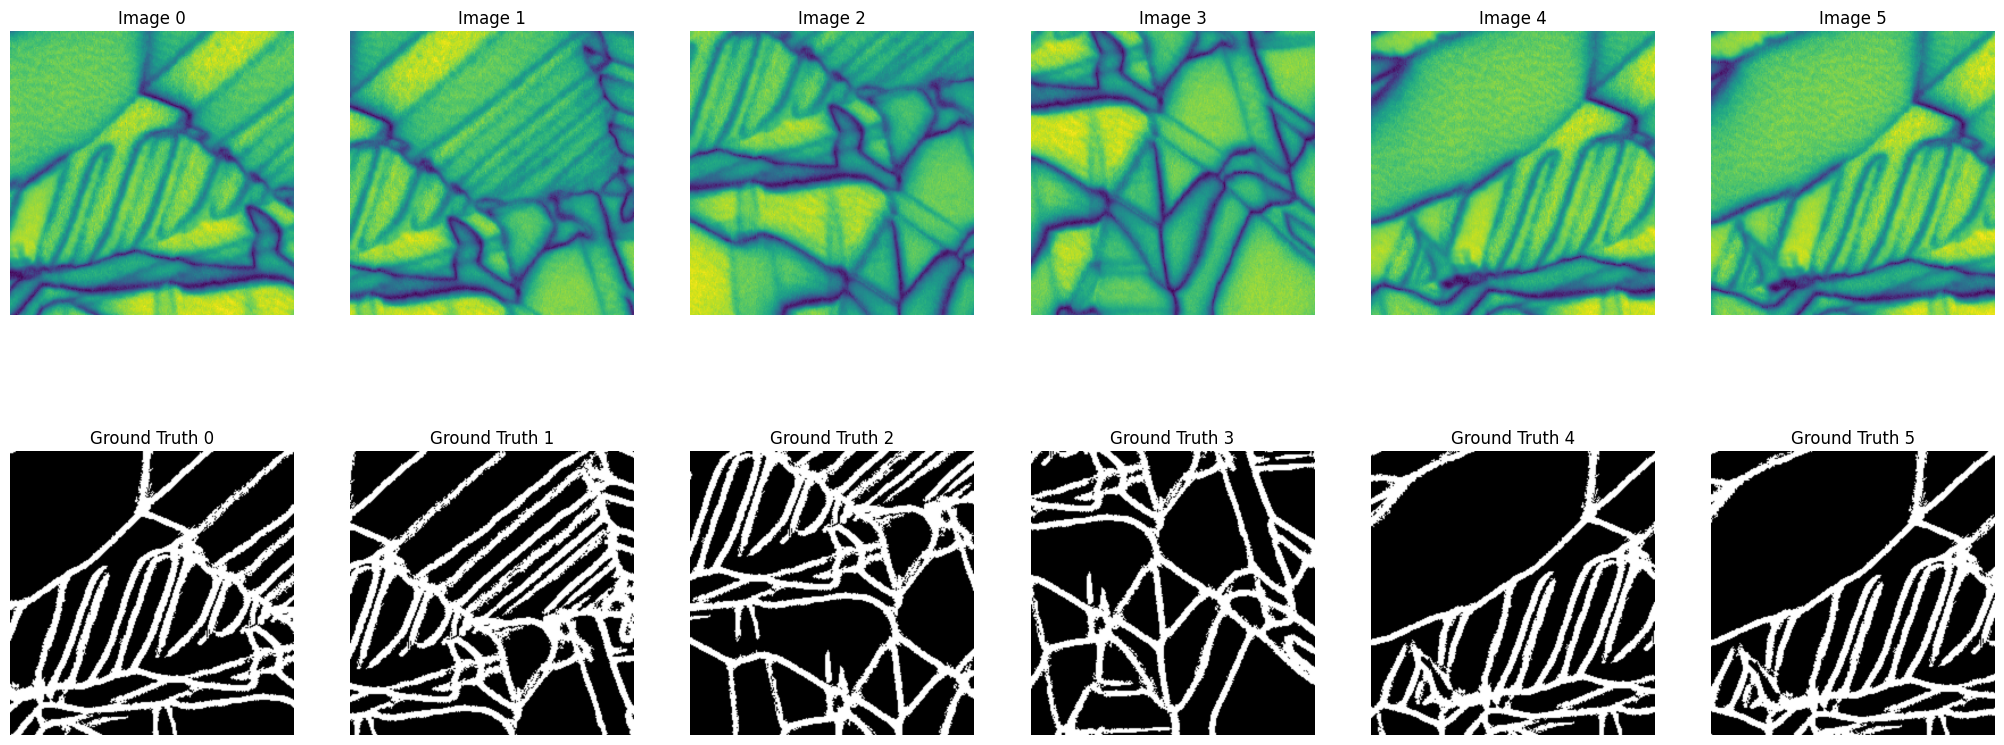

In [6]:
# show validation images
n = 5

n = n + 2
fig = plt.figure(figsize=(30, 10))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_val[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1))
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_val[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_val[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

## **Define and train the model**



In [7]:
etrainer = aoi.trainers.EnsembleTrainer("ResHedNet", nb_classes=1)
etrainer.compile_ensemble_trainer(
    training_cycles=800, loss='focal', batch_size=10, compute_accuracy=True, swa=True)

In [8]:
augment_fn = aoi.transforms.seg_augmentor(
    nb_classes=1, contrast=True, blur=True, rotation=True)

Training ensemble models (strategy = 'from_scratch')

Ensemble model 1
Epoch 1/800 ... Training loss: 0.1107 ... Test loss: 0.0787 ... Train Accuracy: 0.312 ... Test Accuracy: 0.3442 ... GPU memory usage: 11184/15360
Epoch 100/800 ... Training loss: 0.0148 ... Test loss: 0.0196 ... Train Accuracy: 0.7757 ... Test Accuracy: 0.7412 ... GPU memory usage: 11184/15360
Epoch 200/800 ... Training loss: 0.0081 ... Test loss: 0.0098 ... Train Accuracy: 0.8179 ... Test Accuracy: 0.7871 ... GPU memory usage: 11184/15360
Epoch 300/800 ... Training loss: 0.0053 ... Test loss: 0.0059 ... Train Accuracy: 0.8381 ... Test Accuracy: 0.8309 ... GPU memory usage: 11184/15360
Epoch 400/800 ... Training loss: 0.0039 ... Test loss: 0.005 ... Train Accuracy: 0.85 ... Test Accuracy: 0.8337 ... GPU memory usage: 11184/15360
Epoch 500/800 ... Training loss: 0.0027 ... Test loss: 0.0026 ... Train Accuracy: 0.8669 ... Test Accuracy: 0.8631 ... GPU memory usage: 11184/15360
Epoch 600/800 ... Training loss: 0.002 ..

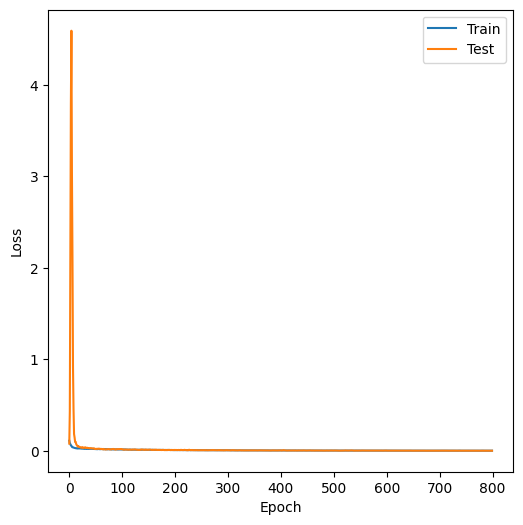

In [9]:
smodel, ensemble = etrainer.train_ensemble_from_scratch(
    x_train, y_train, x_val, y_val, n_models=1, augment_fn=augment_fn,
    filename='Ensemble_ResHedNet_DWs_pzt')

# **Make precition and compare with ground truth**

> Indented block



In [10]:
test = np.load(sorted(glob.glob('*U_mag.npy'))[-1])
test = (test-test.min())/np.ptp(test)

predictor = aoi.predictors.EnsemblePredictor(smodel, ensemble, nb_classes=1)
pred_mean, pred_var = predictor.predict(test)

pred_mean.shape, pred_var.shape

Batch 1/1

((1, 511, 511, 1), (1, 511, 511, 1))

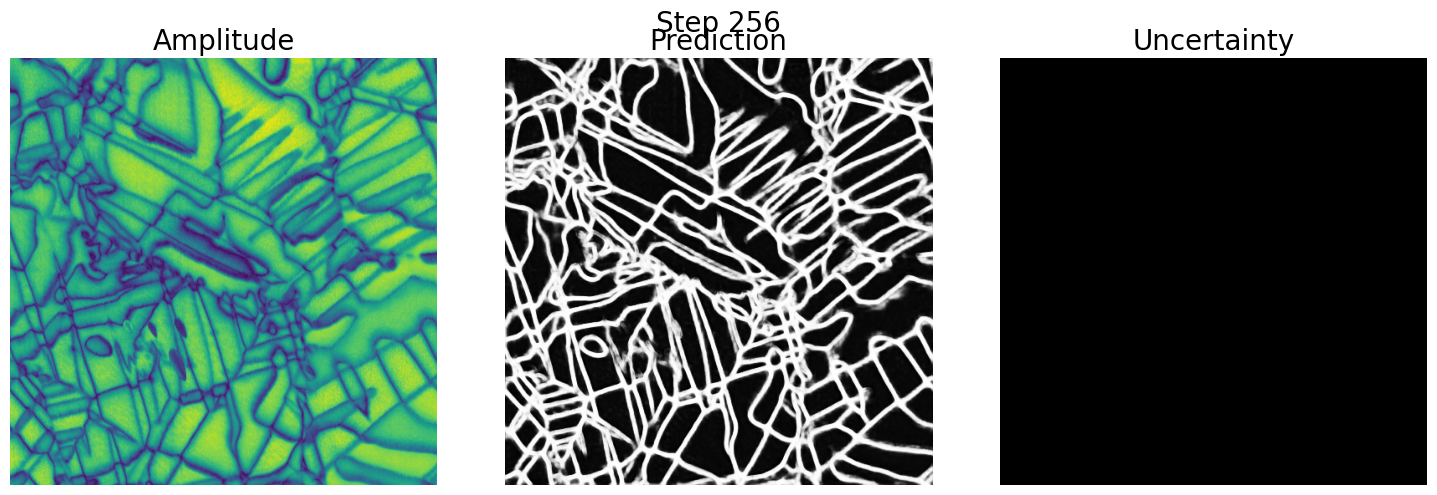

In [11]:
f,(ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
f.subplots_adjust(hspace=0.01, top = 0.97)
f.suptitle("Step 256", fontsize = 20)
ax0.imshow(test)
ax0.axis ('off')
ax0.set_title('Amplitude', fontsize = 20)
ax1.imshow(pred_mean.squeeze(), cmap = 'gray')
ax1.axis('off')
ax1.set_title('Prediction', fontsize = 20)
ax2.imshow(pred_var.squeeze(), cmap = 'gray')
ax2.axis('off')
ax2.set_title('Uncertainty', fontsize = 20)
f.tight_layout()

In [12]:
np.save('Type123Pred', pred_mean.squeeze())

In [13]:
atest = np.load('Type123Pred.npy')

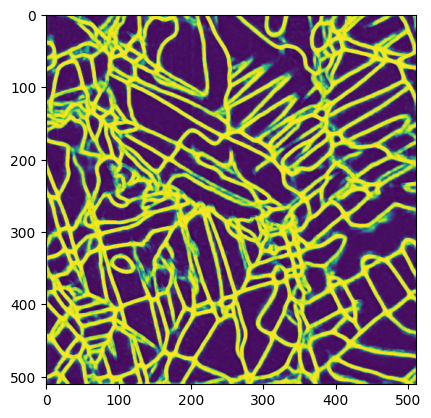

In [14]:
plt.imshow(atest)

Prediction with individual ensemble models: